# Transfer learning using pre-trained DeepSpeech model

Our previous attempt to train a VGG network on dysarthric speech was not successful given the limited amount of training data that is available to us. Instead, we'll attempt to use a highly accurate deep neural net that has been pre-trained on normal speech and then fine-tune it by running some additional epochs to train it on the TORGO data

### a) Install DeepSpeech

First, create a virtual environment using ```conda create -n deepspeech-venv python=3 anaconda```, and then activate it with ```conda activate deepspeech-venv```

Run ```conda install -c anaconda tensorflow``` and ```conda install -c anaconda wget```

Then to get MFCC function, DeepSpeech and the required decoder, need to pip install into the conda environment (packages are not on Anaconda Cloud)

```~/anaconda3/envs/deepspeech-venv/bin/pip install python_speech_features```   
```~/anaconda3/envs/deepspeech-venv/bin/pip install $(python3 util/taskcluster.py --decoder)```
```~/anaconda3/envs/deepspeech-venv/bin/pip install deepspeech```
```~/anaconda3/envs/deepspeech-venv/bin/pip install jupyter```

Collect the DeepSpeech python files using git clone https://github.com/mozilla/DeepSpeech

cd into the DeepSpeech directory
pip3 install -r requirements.txt

Download model files if necessary. In terminal window ```wget https://github.com/mozilla/DeepSpeech/releases/download/v0.4.1/deepspeech-0.4.1-models.tar.gz```
then unzip them with
```tar xvfz deepspeech-0.4.1-models.tar.gz```

### b) Test it out

Save audio files to be translated in a directory, and from the terminal, run 

```deepspeech --model models/output_graph.pbmm --alphabet models/alphabet.txt --lm models/lm.binary --trie models/trie --audio my_audio_file.wav```


### c) Check results for normal and dysarthric speech

In [1]:
# First check that the notebook is running in the virtual environment so that it has
# access to the specific versions of packages that were just installed
import sys
print(sys.executable)

/Users/simonhodgkinson/anaconda3/envs/deepspeech-venv/bin/python


In [2]:
import numpy as np
import pandas as pd
import os
import librosa
import sklearn
%matplotlib inline

In [28]:
# Compare MFCC's for normal and dysarthric speech

def prepare_input(audio_path):
    """Ensures audio matches the sample rate supported by Deep Speech,
       and truncates the audio if there is leading silence
    Args:
        audio_path: path ot the audio file
    Returns:
        A tuple with (sample_rate, converted_audio)    
    """
    
    import librosa
    sample_rate = 16000
    
    audio, fs = librosa.load(audio_path)
    
    if fs != sample_rate:
        print('Resampling audio from {}kHz to 16kHz'.format(fs/1000))
        audio = librosa.resample(audio, fs, sample_rate)
    
    # Trim leading silence
    
    audio_trim, index = librosa.effects.trim(audio, top_db=25)
    return sample_rate, audio_trim


def visualize_input(sample_rate, audio, title):
    """Plots the MFCC using 13 cepstral coefficients
    Args:
        sample_rate: sample rate
        audio: audio sample buffer
        title: plot title
    """
    import matplotlib.pyplot as plt
    from python_speech_features import mfcc
    
    # plot spectrogram
    features = mfcc(audio, sample_rate, winlen=0.025, winstep=0.01,
                    numcep=13, appendEnergy=False)

    fig, ax = plt.subplots(nrows=1, ncols=1, figsize=(20,4))
    cax = ax.matshow(np.transpose(features), interpolation='nearest',
                     aspect='auto', cmap='plasma', origin='lower')
    fig.colorbar(cax)
    
    plt.title(title)
    plt.show()

In [30]:
# Me saying hello my name is Simon
sample_rate1, audio1 = prepare_input('../audio/test_sph.wav')
# Me saying 'some_hotels_are_available_nearby'
sample_rate2, audio2 = prepare_input('../audio/me_some_hotels_are_available_nearby.wav')
# F03 saying 'some_hotels_are_available_nearby'
sample_rate3, audio3 = prepare_input('../audio/F03_0038_some_hotels_are_available_nearby.wav')

Resampling audio from 22.05kHz to 16kHz
Resampling audio from 22.05kHz to 16kHz
Resampling audio from 22.05kHz to 16kHz


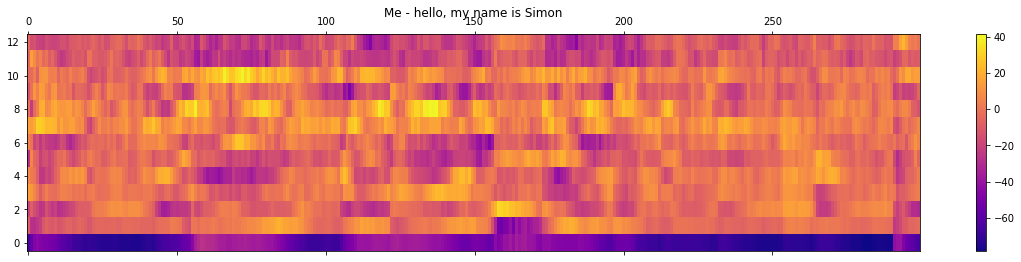

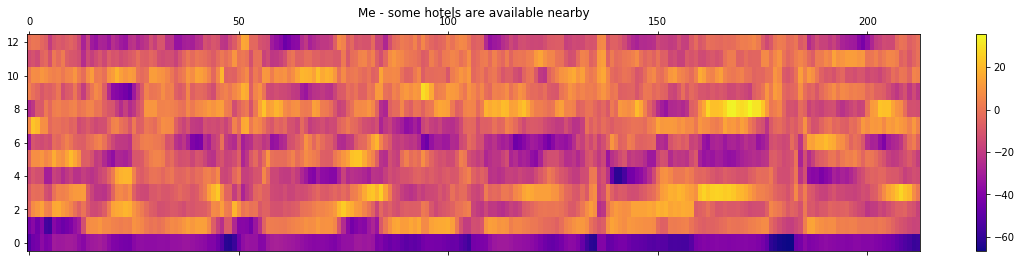

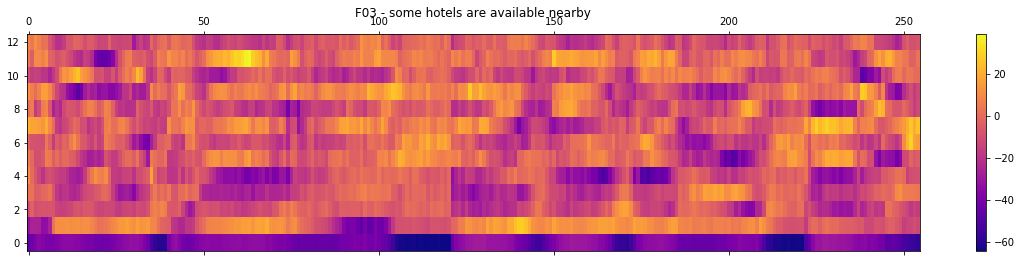

In [31]:
visualize_input(sample_rate1, audio1, "Me - hello, my name is Simon")
visualize_input(sample_rate2, audio2, "Me - some hotels are available nearby")
visualize_input(sample_rate3, audio3, "F03 - some hotels are available nearby")

DeepSpeech correctly translates both phrases spoken by me, but **incorrectly translates the dysarthric phrase as "From mortals are well bonnyboy".**   
  
However, when comparing the MFCC of dysarthric speech to the MFCC's of the correctly translated phrases, the dysarthric speech appears more similar to the same phrase in normal speech, which means that it might be worth exploring whether we can fine tune the model by retraining on dysarthric speech. Judging similarity visually is difficult and can be subjective, so check the DTW distances to be sure.

In [39]:
import sklearn
from numpy.linalg import norm
from fastdtw import fastdtw, dtw
from python_speech_features import mfcc


mfcc_me_1 = mfcc(audio1, sample_rate1, winlen=0.025, winstep=0.01, numcep=13, appendEnergy=False)
mfcc_me_2 = mfcc(audio2, sample_rate2, winlen=0.025, winstep=0.01, numcep=13, appendEnergy=False)
mfcc_f03 = mfcc(audio3, sample_rate3, winlen=0.025, winstep=0.01, numcep=13, appendEnergy=False)

# Scale features
mfcc_me_1 = sklearn.preprocessing.scale(mfcc_me_1, axis=1)
mfcc_me_2 = sklearn.preprocessing.scale(mfcc_me_2, axis=1)
mfcc_f03 = sklearn.preprocessing.scale(mfcc_f03, axis=1)

# mfcc_me_1.shape
# mfcc_f03.shape

# F03 vs Me (incorrect phrase)
distance, path = fastdtw(mfcc_f03, mfcc_me_1, radius=10, dist=lambda x, y: norm(x - y))
print('DTW distance F03 vs incorrect phrase: {0:.2f}'.format(distance))

# F03 vs Me (correct phrase)
distance, path = fastdtw(mfcc_f03, mfcc_me_2, radius=10, dist=lambda x, y: norm(x - y))
print('DTW distance F03 vs correct phrase: {0:.2f}'.format(distance))

DTW distance F03 vs incorrect phrase: 1055.80
DTW distance F03 vs correct phrase: 868.07


## Retraining  
  
#### a) Reformat index file  

To retrain DeepSpeech using TORGO data, we'll need to create a csv file in the correct format. It should contain three columns:  
* full path to the wav file
* size of the wav file
* transcript (using only tokens present in alphabet.txt)

In [207]:
# Need to point this to the folder where the wav files are stored. Full path from home is required
# ie relative assignments won't work
BASE_PATH = '/Users/simonhodgkinson/Desktop/Capstone/mids_capstone/'
# or for GCP
# BASE_PATH = '/home/simon_hodgkinson_gcp/DeepSpeech/audio/'

# Load the existing index for the TORGO data
df = pd.read_csv(BASE_PATH + 'index_TORGO.txt', sep="|", converters={'prompt_id': lambda x: str(x)})

# Remove instances where prompt is None, ends with "]" or contains "jpg"
df['remove'] = (df['prompt']==None) | (df['prompt']=='None') | (df['prompt'].str.contains('jpg')) | (df['prompt'].str.endswith(']')) | (df['prompt']=='xxx') 
df = df.loc[df['remove'] == False].reset_index(drop=True)

# Create a list that will allow us to convert the existing index to the required format
data = []
for p in range(df.shape[0]):
    speaker = df['speaker'][p]
    aud_loc = '/'.join([BASE_PATH+'data/TORGO', df['speaker'][p], df['session'][p], df['mic'][p], df['prompt_id'][p]+'.wav'])           
    filesize = os.path.getsize(aud_loc)
    transcript = df['prompt'][p].strip().lower().replace(',', '').replace('.', '') \
    .replace('!', '').replace('?', '').replace(';', '').replace('-', '') \
    .replace('"', '').replace('[', '').replace('13th', 'thirteenth') 
    data.append((speaker, aud_loc, filesize, transcript))

# turn the list into a new dataframe
df2 = pd.DataFrame(data=data, columns=["speaker", "wav_filename", "wav_filesize", "transcript"])

# Remove items where wav_filesize < 15000 - these are too short for real speech and are typically very
# beeps or buzzes where the recording was abandoned. The shortest 'genuine' recording is
# F03/Session1/wav_headMic/0147.wav, which is the word 'troop' with filelength 17472

df2 = df2[df2['wav_filesize']>17400]


#### Double check that there are no characters left in the transcript column that are not included in the file of valid characters (alphabet.txt)

In [208]:
from collections import Counter
Counter(list(" ".join(list(df2['transcript'].values))))

Counter({'s': 3903,
         't': 4766,
         'i': 4213,
         'c': 1650,
         'k': 998,
         ' ': 13855,
         'e': 7780,
         'x': 157,
         'p': 1401,
         'n': 3297,
         'h': 3065,
         'w': 1688,
         'r': 4315,
         'o': 4423,
         'z': 95,
         'v': 646,
         'a': 4898,
         'u': 1594,
         'm': 1338,
         'l': 3123,
         'y': 1386,
         'd': 1939,
         'b': 1155,
         'g': 1489,
         'f': 1227,
         'q': 56,
         'j': 171,
         "'": 125,
         '\x1b': 40})

#### b) Determine split into -train, -dev and -test files

In [209]:
# We can't randomly assign files to train/test/dev, because the data contains duplicate recordings
# where the only difference is that one is recorded on a head mic, and one is on an array mic
# If one of these gets assigned to train and one to test, it may result in us overstating accuracy
# It would be more realistic to train on certain dysarthric speakers, and assign remaining ones to test
# ie the test case would be on a brand new speaker

total_filesize = df2.groupby(['speaker']).sum()
print(total_filesize)
total_percentage = total_filesize.groupby(level=0).apply(lambda x: 100 * x/total_filesize['wav_filesize'].sum())
total_percentage.rename(columns = {'wav_filesize':'% of total time'}, inplace = True)
total_percentage


         wav_filesize
speaker              
F01          17932030
F03          95443490
F04          70222074
M01         118207546
M02          90616182
M03          81220496
M04          90921178
M05          86268498


,% of total time
speaker,
F01,2.755249
F03,14.664854
F04,10.789594
M01,18.162542
M02,13.923140
M03,12.479497
M04,13.970003
M05,13.255120


In [210]:
# So, to get roughly 80/10/10 split, we could assign M03 to dev, and M05 to test
# Create new subsets, but drop the speaker column, which is not part of the DeepSpeech format

df_dev = df2[df2['speaker']=='M03']
del df_dev['speaker']

df_test = df2[df2['speaker']=='M05']
del df_test['speaker']

df_train = df2[~df2['speaker'].isin(['M03','F04'])]
del df_train['speaker']

df_train.head()

,wav_filename,wav_filesize,transcript
0,/Users/simonhodgkinson/Desktop/Capstone/mids_c...,44824,stick
1,/Users/simonhodgkinson/Desktop/Capstone/mids_c...,315044,except in the winter when the ooze or snow or ...
2,/Users/simonhodgkinson/Desktop/Capstone/mids_c...,40192,pat
3,/Users/simonhodgkinson/Desktop/Capstone/mids_c...,66442,up
4,/Users/simonhodgkinson/Desktop/Capstone/mids_c...,51002,meat


**Note that M03 is classified as mildly dysarthric, while M05 is moderately severe.** It may be worth switching these around to see what the impact is.

| Speaker | Disorder | Utterances |
|---------|----------|------------|
|F01 | Severe | 228 |
|M01 | Severe | 739 |
|M02 | Severe | 772 |
|M04 | Severe | 659 |
|M05 | Mod. Severe | 610 |
|F03 | Moderate | 1097 |
|F04 | Mild | 675 |
|M03 | Mild | 806 |


#### c) Create the csv files

In [211]:
df_dev.to_csv(BASE_PATH + "TORGO_dev.csv", index=False)
df_test.to_csv(BASE_PATH + "TORGO_test.csv", index=False)
df_train.to_csv(BASE_PATH + "TORGO_train.csv", index=False)

Move these files from BASE_PATH to /DeepSpeech/data/TORGO

#### d) Preprocess audio  

See DeepSpeech/util/audio.py. DeepSpeech uses scipy.wavfile to process audio files, but this results in an error for many files, which seem to be missing a chunk_id. A simple way to fix this is to open the file using librosa (which standardizes the format) and then resave it.

In [161]:
# Example of files that fail to open properly

from scipy.io import wavfile as wav

for x in list(df_dev['wav_filename']):
    try:
        fs, audio = wav.read(x)
    except:
        print("can't read ", x)

can't read  /Users/simonhodgkinson/Desktop/Capstone/mids_capstone/data/TORGO/M03/Session2/wav_headMic/0419.wav
can't read  /Users/simonhodgkinson/Desktop/Capstone/mids_capstone/data/TORGO/M03/Session2/wav_headMic/0420.wav
can't read  /Users/simonhodgkinson/Desktop/Capstone/mids_capstone/data/TORGO/M03/Session2/wav_headMic/0421.wav


In [162]:
# Fix by using librosa

for x in list(df_dev['wav_filename']):
    try:
        fs, audio = wav.read(x)
    except:
        print('Processing file ',x)
        audio, fs = librosa.load(x)
        librosa.output.write_wav(x, audio, fs)

print("All files checked")

Processing file  /Users/simonhodgkinson/Desktop/Capstone/mids_capstone/data/TORGO/M03/Session2/wav_headMic/0419.wav
Processing file  /Users/simonhodgkinson/Desktop/Capstone/mids_capstone/data/TORGO/M03/Session2/wav_headMic/0420.wav
Processing file  /Users/simonhodgkinson/Desktop/Capstone/mids_capstone/data/TORGO/M03/Session2/wav_headMic/0421.wav
All files checked


In [166]:
for x in list(df_dev['wav_filename']):
    try:
        fs, audio = wav.read(x)
    except:
        print("can't read ", x)
        
print("All files checked")

All files checked


In [164]:
# Do this for the whole dataset

for x in list(df2['wav_filename']):
    try:
        fs, audio = wav.read(x)
    except:
        print('Processing file ',x)
        audio, fs = librosa.load(x)
        librosa.output.write_wav(x, audio, fs)

print("All files checked")

Processing file  /Users/simonhodgkinson/Desktop/Capstone/mids_capstone/data/TORGO/F03/Session2/wav_headMic/0160.wav
Processing file  /Users/simonhodgkinson/Desktop/Capstone/mids_capstone/data/TORGO/F03/Session3/wav_headMic/0214.wav
Processing file  /Users/simonhodgkinson/Desktop/Capstone/mids_capstone/data/TORGO/M01/Session1/wav_headMic/0005.wav
Processing file  /Users/simonhodgkinson/Desktop/Capstone/mids_capstone/data/TORGO/M01/Session1/wav_headMic/0006.wav
Processing file  /Users/simonhodgkinson/Desktop/Capstone/mids_capstone/data/TORGO/M01/Session1/wav_headMic/0007.wav
Processing file  /Users/simonhodgkinson/Desktop/Capstone/mids_capstone/data/TORGO/M01/Session1/wav_headMic/0008.wav
Processing file  /Users/simonhodgkinson/Desktop/Capstone/mids_capstone/data/TORGO/M01/Session1/wav_headMic/0009.wav
Processing file  /Users/simonhodgkinson/Desktop/Capstone/mids_capstone/data/TORGO/M01/Session1/wav_headMic/0010.wav
Processing file  /Users/simonhodgkinson/Desktop/Capstone/mids_capstone/d

Processing file  /Users/simonhodgkinson/Desktop/Capstone/mids_capstone/data/TORGO/M01/Session1/wav_headMic/0079.wav
Processing file  /Users/simonhodgkinson/Desktop/Capstone/mids_capstone/data/TORGO/M01/Session1/wav_headMic/0080.wav
Processing file  /Users/simonhodgkinson/Desktop/Capstone/mids_capstone/data/TORGO/M01/Session1/wav_headMic/0082.wav
Processing file  /Users/simonhodgkinson/Desktop/Capstone/mids_capstone/data/TORGO/M01/Session1/wav_headMic/0083.wav
Processing file  /Users/simonhodgkinson/Desktop/Capstone/mids_capstone/data/TORGO/M01/Session1/wav_headMic/0084.wav
Processing file  /Users/simonhodgkinson/Desktop/Capstone/mids_capstone/data/TORGO/M01/Session1/wav_headMic/0085.wav
Processing file  /Users/simonhodgkinson/Desktop/Capstone/mids_capstone/data/TORGO/M01/Session1/wav_headMic/0086.wav
Processing file  /Users/simonhodgkinson/Desktop/Capstone/mids_capstone/data/TORGO/M01/Session1/wav_headMic/0087.wav
Processing file  /Users/simonhodgkinson/Desktop/Capstone/mids_capstone/d

In [212]:
for x in list(df2['wav_filename']):
    try:
        fs, audio = wav.read(x)
    except:
        print("can't read ", x)

print("All files checked")

All files checked


In [213]:
##### Don't need to do this if you install sox (sudo apt-get install sox libsox-fmt-mp3) ######

# Now there is an error 
# "frame length (706) is greater than FFT size (512), frame will be truncated. Increase NFFT to avoid"
# Apparently need to downsample to 16,000 to solve

# sample_rate = 16000

# for x in list(df2['wav_filename']):
#     audio, fs = librosa.load(x)
#     librosa.output.write_wav(x, audio, sample_rate)

# print("All files downsampled to 16000 Hz")


All files downsampled to 16000 Hz


## Run DeepSpeech

First, download appropriate pretrained checkpoint and place it in a new folder in the DeepSpeech directory  

cd DeepSpeech  
mkdir fine_tuning_checkpoints
mkdir tensorboard_summaries
cd fine_tuning_checkpoints  
wget https://github.com/mozilla/DeepSpeech/releases/download/v0.5.0-alpha.4/deepspeech-0.5.0a4-cp37-cp37m-macosx_10_10_x86_64.whl

Then, back in DeepSpeech root directory  

cd ../  
  
python3 DeepSpeech.py --n_hidden 2048 --checkpoint_dir ./fine_tuning_checkpoints --epoch -3 --train_files ./data/TORGO/TORGO_train.csv --dev_files ./data/TORGO/TORGO_dev.csv --test_files ./data/TORGO/TORGO_test.csv --learning_rate 0.0001  --summary_dir ./tensorboard_summaries

Since the pretrained model used 2048 hidden nodes, we need to do the same. Epoch negative three means to train for three more epochs in addition to how ever many epochs the pretrained model has been through.

**Note**

Execution stopped for me, with the error  
  
OMP: Error #15: Initializing libiomp5.dylib, but found libiomp5.dylib already initialized.
OMP: Hint: This means that multiple copies of the OpenMP runtime have been linked into the program. That is dangerous, since it can degrade performance or cause incorrect results. The best thing to do is to ensure that only a single OpenMP runtime is linked into the process, e.g. by avoiding static linking of the OpenMP runtime in any library. As an unsafe, unsupported, undocumented workaround you can set the environment variable KMP_DUPLICATE_LIB_OK=TRUE to allow the program to continue to execute, but that may cause crashes or silently produce incorrect results. For more information, please see http://www.intel.com/software/products/support/.

This was fixed by running ```conda install nomkl```

Monitor progress by running ```tensorboard --logdir=./tensorboard_summaries``` in a terminal, and then in a new browser window open http://localhost:6006